# Grid Trading Bot 

Build a simple grid trading algorithm, introduce concepts to readers such as Transaction costs, stop losses and order sizing

In [1]:
#import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backtrader as bt
from datetime import datetime
import os

from alpha_vantage.foreignexchange import ForeignExchange
import warnings

In [2]:
#Configure certain elements to work best in Jupyterlab
%matplotlib inline
# I add the line below to let the plots take advantage of my Macbook Retina screen, feel free to remove
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.figsize'] = 16,9
pd.set_option('display.max_colwidth', -1)
warnings.filterwarnings('ignore')

## Gather FX Historical Data
I will use Alpha vantage to gather historical data, in order for you to collect data yourself, you'll need to create an free account. visit the website
https://www.alphavantage.co/ and follow the instructions there. <br>
<br>
It's never a good practice to copy your credentials as free text into your code.
I've placed my credentials in a .env file which stays with me locally.

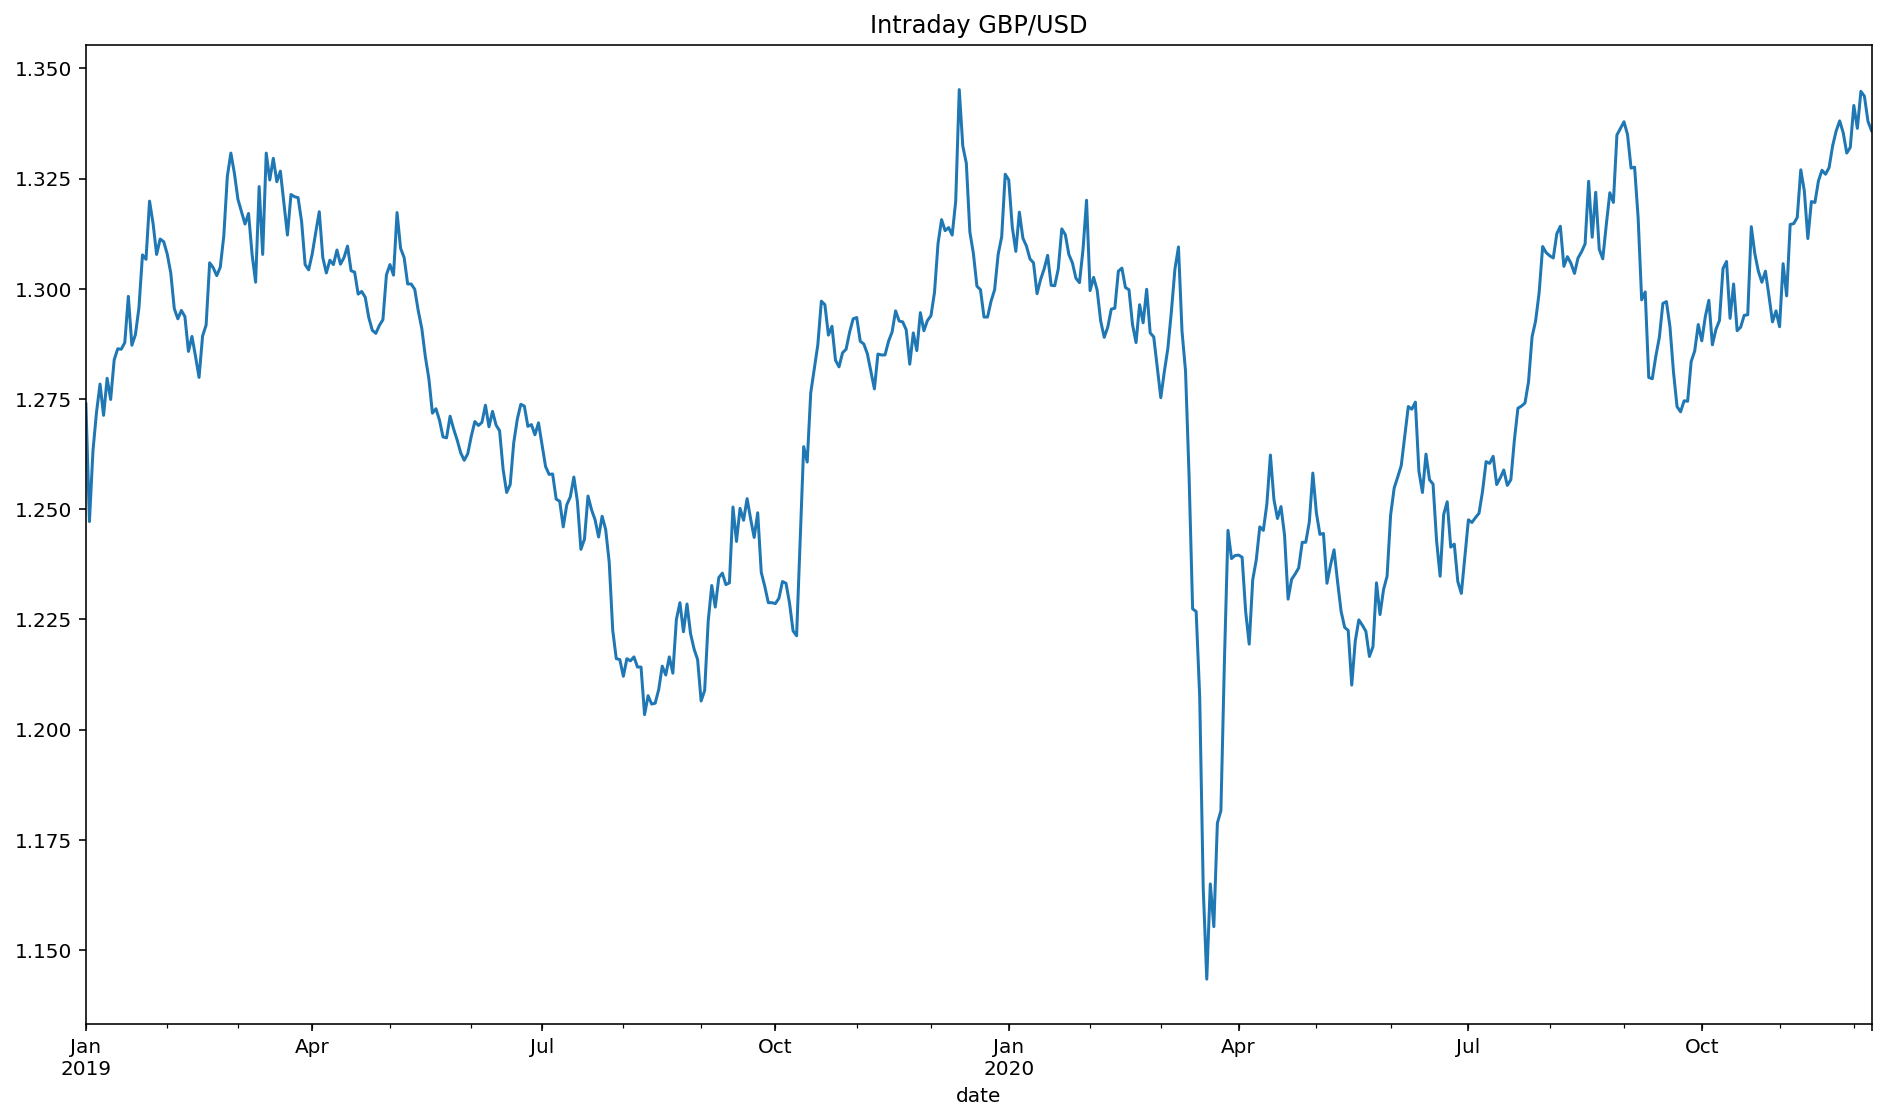

In [3]:
cc = ForeignExchange(key=os.environ['alpha_vantage_token'],output_format='pandas')

# We will retreive daily OHLC prices, Alpha vantage also contains intraday results which are difficult to come by elsewhere

data_df, metadata_df = cc.get_currency_exchange_daily(from_symbol='GBP',to_symbol='USD', outputsize='full')

# Let's just look at 2015 onwards 

data_df.sort_index(inplace=True)
data_df = data_df.loc['2019-01-01':]

# Plot the results to ensure everything worked

data_df['4. close'].plot()
plt.title('Intraday GBP/USD')
plt.show()

In [4]:
# Rename & rearrange the fields so they can be ingested by Backtrader
data_df = data_df.loc[:, ['2. high', '3. low', '1. open', '4. close']]
data_df.columns = ['High', 'Low', 'Open', 'Close']

# Algorithm Strategy Definition 
To do the backtesting, we will use the Backtrader Python package https://www.backtrader.com/. It's a bigger learning curve to compared to other platforms such as Quantopian, but I really enjoy the added flexibility and the fact you can easily integrate with other Python packages/platforms.

In [163]:
class grid_bander_bands(bt.Strategy):
    
    def log(self, txt, dt=None, time=None):
        """ Logging function for this strategy"""
        dt = dt or self.data0.datetime.date(0)
        time = time or self.data0.datetime.time(0)
        print('%s %s, %s' % (dt.isoformat(), time.isoformat(), txt))
    
        
    def notify_trade(self, trade):
        if trade.justopened:
            print('----TRADE OPENED----')
            print('Size: %f, Price: %f, Value: %f, ref: %f' % (trade.size, trade.price, trade.value, trade.ref))
            print('-' * 25)
        elif trade.isclosed:
            print('----TRADE CLOSED----')
            print('Profit, Gross {}, Net {}, Price {}, Ref: {}'.format(
                trade.pnl,
                trade.pnlcomm,
                trade.price,
                trade.ref))
            print('-' * 25)
        else:
            return
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            self.log('ORDER ACCEPTED/SUBMITTED')
            self.order = order
            return


        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log("ORDER REFERENCE: %f, BUY EXECUTED, %f, MARGIN REMAINING: %f" % (order.ref, order.executed.price, cerebro.broker.get_cash()))
            elif order.issell():
                self.log("ORDER REFERENCE: %f, SELL EXECUTED, %f. BALANCE: %f. MARGIN REMAINING: %f." %
                         (order.ref,
                          order.executed.price,
                          cerebro.broker.getvalue(),
                          cerebro.broker.get_cash()
                          ))
        

        if not order.alive():
            self.order = None  # indicate no order is pending 


    def start(self):
        self.order = None  # sentinel to avoid operations on pending order    
    
    
    
    def __init__(self):
        
        # Sentinel to None: new orders allowed
        self.order = None
    
    def next(self):
        
        
        if self.order:
            # An order is pending ... nothing can be done
            return
        
        # Check we are not in the market
        if not self.position:
                self.order = self.buy(price=1.225, exectype=bt.Order.Limit, size=1000)
        
        self.order = self.close(price=1.275, exectype=bt.Order.Limit)

## Run the strategy over the last 2 years 

In [164]:
%%time
cerebro = bt.Cerebro()
data = bt.feeds.PandasData(dataname=data_df)
cerebro.adddata(data)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addstrategy(grid_bander_bands)
results = cerebro.run()

2019-01-02 00:00:00, ORDER ACCEPTED/SUBMITTED
2019-01-02 00:00:00, ORDER ACCEPTED/SUBMITTED
2019-07-29 00:00:00, ORDER REFERENCE: 4829.000000, BUY EXECUTED, 1.225000, MARGIN REMAINING: 8775.000000
----TRADE OPENED----
Size: 1000.000000, Price: 1.225000, Value: 1225.000000, ref: 87.000000
-------------------------
2019-07-30 00:00:00, ORDER ACCEPTED/SUBMITTED
2019-07-30 00:00:00, ORDER ACCEPTED/SUBMITTED
2019-10-15 00:00:00, ORDER REFERENCE: 4830.000000, SELL EXECUTED, 1.275000. BALANCE: 10050.000000. MARGIN REMAINING: 10050.000000.
----TRADE CLOSED----
Profit, Gross 49.99999999999982, Net 49.99999999999982, Price 1.225, Ref: 87
-------------------------
2019-10-16 00:00:00, ORDER ACCEPTED/SUBMITTED
2019-10-16 00:00:00, ORDER ACCEPTED/SUBMITTED
2020-03-16 00:00:00, ORDER REFERENCE: 4831.000000, BUY EXECUTED, 1.225000, MARGIN REMAINING: 8825.000000
----TRADE OPENED----
Size: 1000.000000, Price: 1.225000, Value: 1225.000000, ref: 88.000000
-------------------------
2020-03-17 00:00:00, OR

Sharpe: 3.167
Norm. Annual Return: 5.81%
Max Drawdown: 6.41%


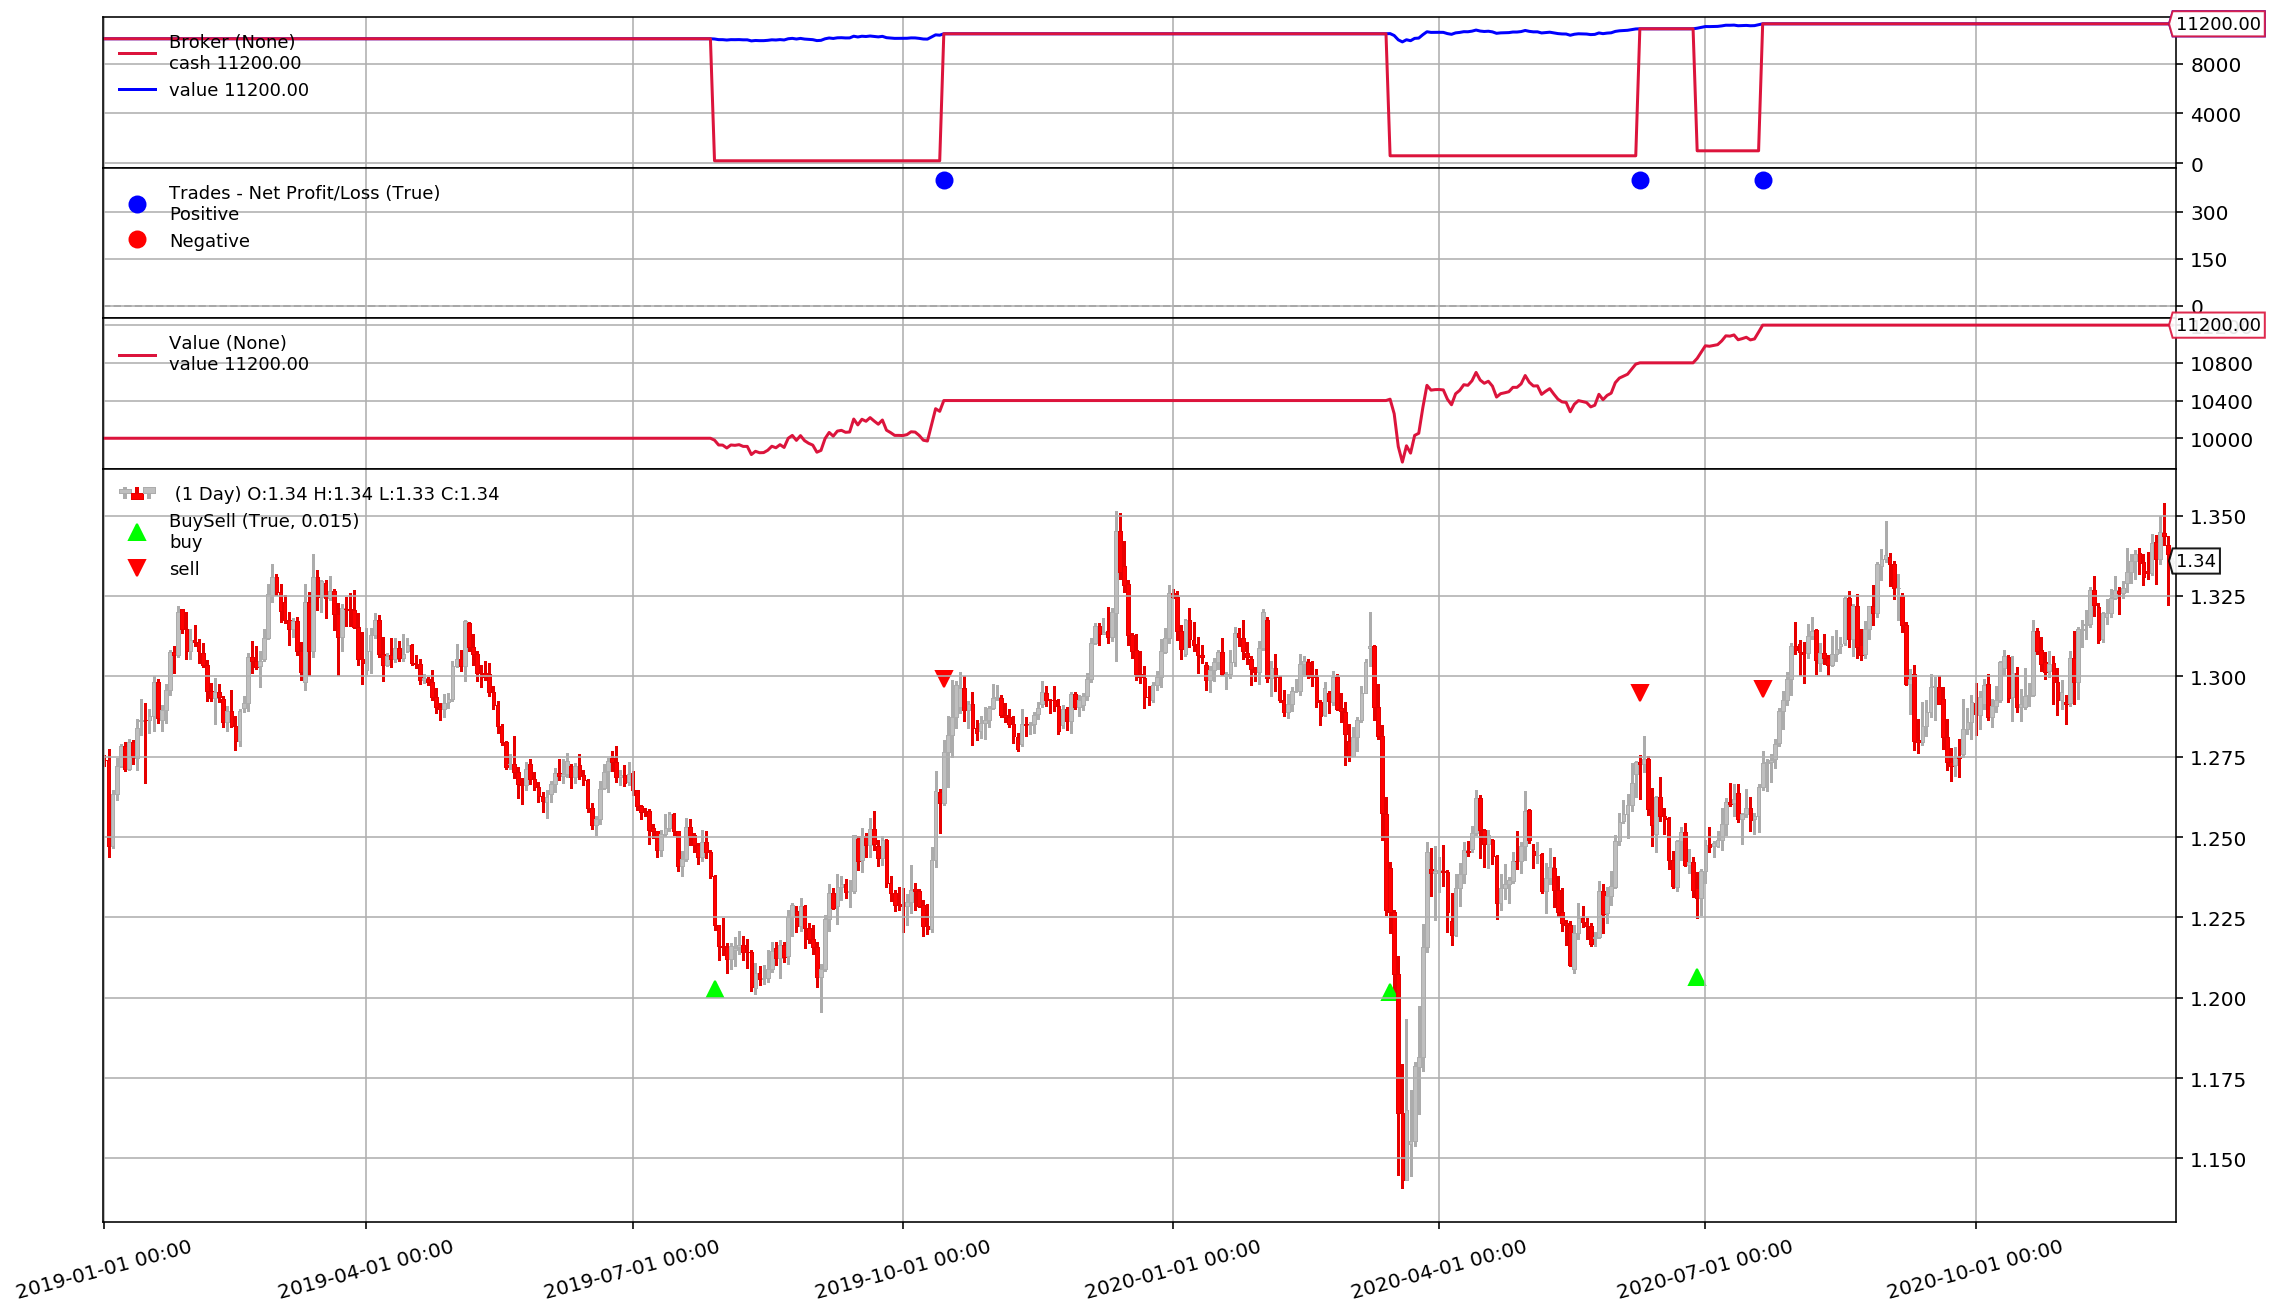

[[<Figure size 1152x648 with 4 Axes>]]

In [162]:
print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")
cerebro.plot(iplot=False, volume=False, width=45, style='candle')